In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [23]:
#Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

# Load Data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [25]:
# Turning all the hidden values to nan:
#df = df.replace(r'^\s*$', np.nan, regex=True)
#print(df.isnull().sum())

In [27]:
#PREPROCESSING

# Handling Missing Values
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
#print the null counting in every column
print(df.isnull().sum())
# Converting empty strings to NaN
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
#Converting to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
#Filling empty with median
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Removing Duplicates
df.drop_duplicates(inplace=True)

# Outlier Handling
Q1 = df['TotalCharges'].quantile(0.25)
Q3 = df['TotalCharges'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['TotalCharges'] < (Q1 - 1.5 * IQR)) | (df['TotalCharges'] > (Q3 + 1.5 * IQR)))]

# Encoding
# We use Label Encoding for binary features and One-Hot for multi-category
le = LabelEncoder()
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-Hot Encoding for multi-category features
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [29]:
#for removing all the outliers for the data
    
#num_cols = df.select_dtypes(include=['int64', 'float64']).columns

#for col in num_cols:
#    Q1 = df[col].quantile(0.25)
#    Q3 = df[col].quantile(0.75)
#    IQR = Q3 - Q1
#    lower = Q1 - 1.5 * IQR
#    upper = Q3 + 1.5 * IQR
#    df = df[(df[col] >= lower) & (df[col] <= upper)]

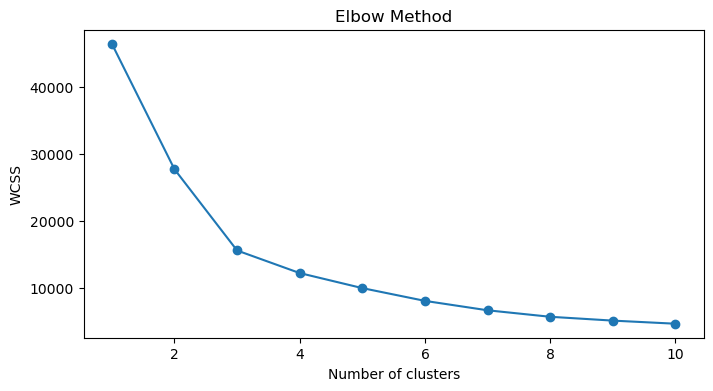

In [33]:
# Features
X = df.drop(['customerID', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
             'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Elbow Method for KMeans
wcss = []
for i in range(1, 11):
    kmeans_test = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans_test.fit(X_pca)
    wcss.append(kmeans_test.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

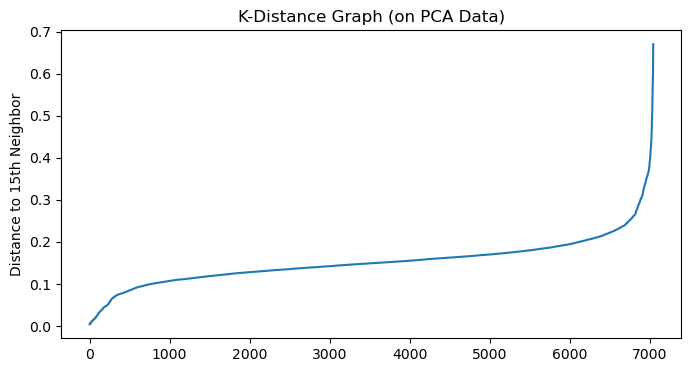

Best eps found: 0.25 with Silhouette Score: 0.1545


In [13]:
# KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)

# --- DBSCAN Tuning ---
# Use K-distance graph to suggest eps
neighbors = NearestNeighbors(n_neighbors=15)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)
distances = np.sort(distances[:, 14], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.ylabel('Distance to 15th Neighbor')
plt.show()

# Try multiple eps values automatically
eps_values = [0.2, 0.25, 0.3, 0.35, 0.4]
best_eps = None
best_score = -1
best_labels = None

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=10)
    labels = dbscan.fit_predict(X_pca)
    mask = labels != -1
    if len(set(labels[mask])) > 1:
        sil = silhouette_score(X_pca[mask], labels[mask])
        if sil > best_score:
            best_score = sil
            best_eps = eps
            best_labels = labels

print(f"Best eps found: {best_eps} with Silhouette Score: {best_score:.4f}")

# Final DBSCAN with best eps
dbscan = DBSCAN(eps=best_eps, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_pca)

In [15]:
# Evaluation
def evaluate_clustering(name, labels, data):
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    if n_clusters > 1:
        mask = labels != -1
        score_data = data[mask]
        score_labels = labels[mask]
        sil = silhouette_score(score_data, score_labels)
        db = davies_bouldin_score(score_data, score_labels)
        print(f"--- {name} Metrics ---")
        print(f"Clusters Found: {n_clusters}")
        print(f"Silhouette Score: {sil:.4f}")
        print(f"Davies-Bouldin Index: {db:.4f}\n")
    else:
        print(f"--- {name} failed: Only {n_clusters} cluster(s) found. ---\n")

evaluate_clustering("k-Means", kmeans_labels, X_pca)
evaluate_clustering("DBSCAN", dbscan_labels, X_pca)

--- k-Means Metrics ---
Clusters Found: 3
Silhouette Score: 0.4294
Davies-Bouldin Index: 0.7799

--- DBSCAN Metrics ---
Clusters Found: 2
Silhouette Score: 0.1545
Davies-Bouldin Index: 0.6425



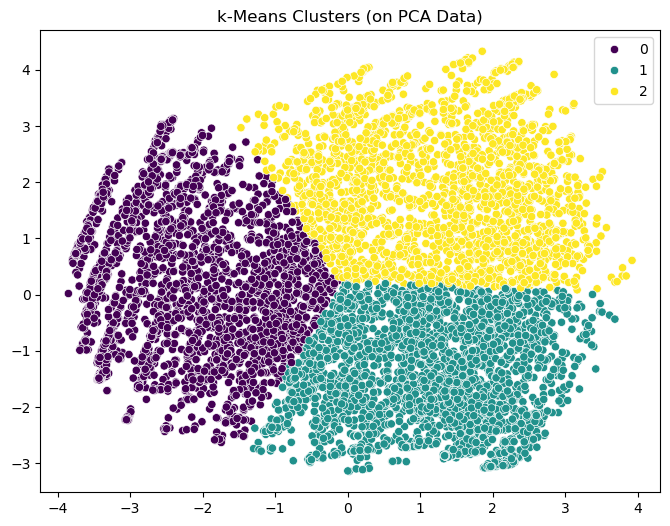

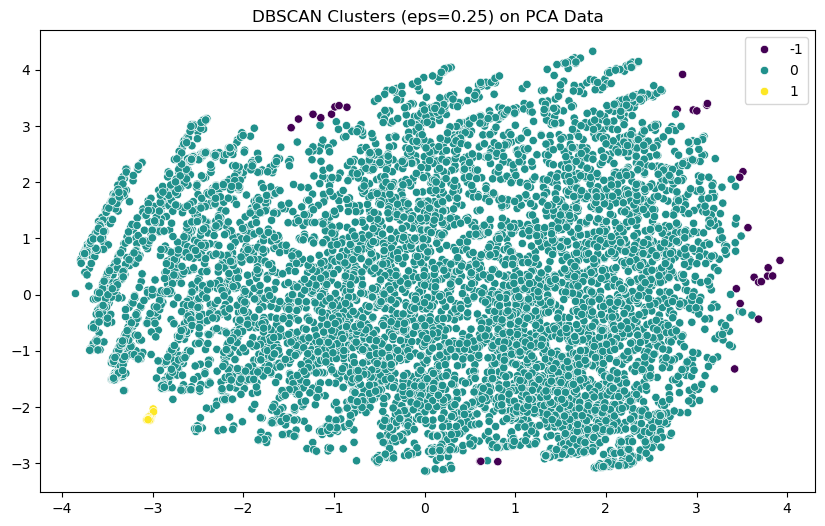

In [16]:
# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis')
plt.title('k-Means Clusters (on PCA Data)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette='viridis', legend='full')
plt.title(f'DBSCAN Clusters (eps={best_eps}) on PCA Data')
plt.show()